In [1]:
import sys
!{sys.executable} -m pip install keras tensorflow --upgrade
!{sys.executable} -m pip install keras_tuner

import os
import json
import time
from typing import Tuple, Dict

import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.models import load_model

In [2]:
# Constants for file paths
RAW_DATA_PATH = "../data/raw/training_data.npz"
SCALER_PATH = "../data/processed/scalers/feature_scaler.pkl"
MODEL_DIR = "../src/models"
LOG_DIR = "logs/train_runs"
RESULTS_JSON = "../src/results/nn_results.json"

os.makedirs(os.path.dirname(SCALER_PATH), exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [3]:
# Training hyperparameters (can be tuned later)
EPOCHS = 80
BATCH_SIZE = 1024
LEARNING_RATE = 3e-4
PATIENCE_ES = 10
PATIENCE_RLROP = 5

# Data split
TEST_SIZE = 0.10
VAL_SIZE = 0.10
RANDOM_STATE = 42

# Device info
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPUs: []


In [4]:
def load_raw_data(path: str) -> Tuple[np.ndarray, np.ndarray]:
    d = np.load(path)
    X = d["X"]
    y = d["y"]
    print(f"Loaded raw data: X={X.shape}, y={y.shape}")
    return X, y

def split_data(X: np.ndarray, y: np.ndarray, test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_STATE):
    # First split off test
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Now split train/val from remaining
    val_fraction_of_remaining = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_fraction_of_remaining, random_state=random_state)
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_features_save_scaler(X_train, X_val, X_test, scaler_path=SCALER_PATH):
    """
    Scale all columns except the last (option_flag). Save StandardScaler to disk.
    Returns processed arrays.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[:, :-1])
    X_val_scaled = scaler.transform(X_val[:, :-1])
    X_test_scaled = scaler.transform(X_test[:, :-1])


    # Append option flag as last column (unchanged)
    X_train_proc = np.hstack([X_train_scaled, X_train[:, -1].reshape(-1, 1)])
    X_val_proc = np.hstack([X_val_scaled, X_val[:, -1].reshape(-1, 1)])
    X_test_proc = np.hstack([X_test_scaled, X_test[:, -1].reshape(-1, 1)])


    joblib.dump(scaler, scaler_path)
    print(f"Saved scaler to {scaler_path}")
    return X_train_proc, X_val_proc, X_test_proc, scaler

In [5]:
INPUT_DIM = 20 # prefix_len (10) + min,max,mean,std (4) + realized_vol (1) + params (5) = 20

def mlp_quick(input_dim=INPUT_DIM):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="linear")(x)
    m = models.Model(inp, out, name="mlp_quick")
    return m

def mlp_large(input_dim=INPUT_DIM):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation="relu")(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(1, activation="linear")(x)
    m = models.Model(inp, out, name="mlp_large")
    return m

def residual_block(x, units):
    shortcut = x
    x = layers.Dense(units, activation="relu")(x)
    x = layers.Dense(units, activation=None)(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation("relu")(x)
    return x

def mlp_residual(input_dim=INPUT_DIM, deep=False):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    if deep:
        # deeper residual stack
        for u in [256, 256, 256, 256]:
            x = residual_block(x, u)
    else:
        for u in [256, 256]:
            x = residual_block(x, u)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(1, activation="linear")(x)
    name = "mlp_large_deep_residual" if deep else "mlp_large_residual"
    m = models.Model(inp, out, name=name)
    return m

def mlp_advanced(input_dim=INPUT_DIM):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(512)(inp)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("gelu")(x)

    # Skip connection: ensure shapes match
    x1 = layers.Dense(512, activation="gelu")(x)
    x1 = layers.Dropout(0.2)(x1)
    x2 = layers.Dense(512, activation="gelu")(x1)
    x2 = layers.Dense(512, activation=None)(x2)
    x = layers.Add()([x1, x2])
    x = layers.Activation("gelu")(x)
    x = layers.Dense(128, activation="gelu")(x)
    out = layers.Dense(1, activation="linear")(x)
    m = models.Model(inp, out, name="mlp_large_advanced")
    return m

In [6]:
def compile_and_get_callbacks(model_name: str, steps_per_epoch: int):
    total_steps = EPOCHS * steps_per_epoch
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=LEARNING_RATE,
        decay_steps=total_steps,
        alpha=1e-5  # final minimum LR
    )
    opt = optimizers.Adam(learning_rate=lr_schedule)

    es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, restore_best_weights=True, verbose=1)
    ckpt = callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, f"{model_name}.keras"),
        monitor="val_loss", save_best_only=True, verbose=1
    )
    tb = callbacks.TensorBoard(
        log_dir=os.path.join(LOG_DIR, model_name + "_" + time.strftime('%Y%m%d-%H%M%S'))
    )
    return opt, [es, ckpt, tb]

def train_model(model_constructor, model_name: str, X_train_proc, y_train, X_val_proc, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE):
    print(f"\n--- Training {model_name} ---")
    model = model_constructor()
    best_path = os.path.join(MODEL_DIR, f"{model_name}.keras")
    
    steps_per_epoch = max(1, X_train_proc.shape[0] // batch_size)
    opt, cbs = compile_and_get_callbacks(model_name, steps_per_epoch)
    
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])

    history = model.fit(
        X_train_proc, y_train,
        validation_data=(X_val_proc, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cbs,
        verbose=2,
    )

    if not os.path.exists(best_path):
        model.save(best_path)

    best_model = load_model(best_path, compile=False)
    best_model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse", metrics=["mae"])
    return best_model, history

In [7]:
X, y = load_raw_data(RAW_DATA_PATH)

Loaded raw data: X=(200000, 20), y=(200000,)


In [8]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

Train: (160000, 20), Val: (20000, 20), Test: (20000, 20)


In [9]:
X_train_proc, X_val_proc, X_test_proc, scaler = scale_features_save_scaler(X_train, X_val, X_test)

Saved scaler to ../data/processed/scalers/feature_scaler.pkl


In [10]:
models_to_train = {
    "mlp_quick": lambda: mlp_quick(INPUT_DIM),
    "mlp_large": lambda: mlp_large(INPUT_DIM),
    "mlp_large_residual": lambda: mlp_residual(INPUT_DIM, deep=False),
    "mlp_large_deep_residual": lambda: mlp_residual(INPUT_DIM, deep=True),
    "mlp_large_advanced": lambda: mlp_advanced(INPUT_DIM),
}
results = {}

for name, ctor in models_to_train.items():
    try:
        model, history = train_model(ctor, name, X_train_proc, y_train, X_val_proc, y_val)

        loss, mae = model.evaluate(X_test_proc, y_test, verbose=0)
        print(f"Test loss (MSE) for {name}: {loss:.6f}, MAE: {mae:.6f}")

        preds = model.predict(X_test_proc[:10]).flatten()
        sample_compare = list(zip(y_test[:10].tolist(), preds.tolist()))

        results[name] = {
            "test_mse": float(loss),
            "test_mae": float(mae),
            "sample_compare": sample_compare,
        }

    except Exception as e:
        print(f"Failed training {name}: {e}")
        results[name] = {"error": str(e)}


--- Training mlp_quick ---
Epoch 1/80

Epoch 1: val_loss improved from None to 162.74948, saving model to ../src/models\mlp_quick.keras
157/157 - 1s - 7ms/step - loss: 203.7430 - mae: 9.4059 - val_loss: 162.7495 - val_mae: 10.3077
Epoch 2/80

Epoch 2: val_loss improved from 162.74948 to 111.36686, saving model to ../src/models\mlp_quick.keras
157/157 - 0s - 2ms/step - loss: 138.7618 - mae: 9.4665 - val_loss: 111.3669 - val_mae: 8.2160
Epoch 3/80

Epoch 3: val_loss improved from 111.36686 to 77.44982, saving model to ../src/models\mlp_quick.keras
157/157 - 0s - 2ms/step - loss: 90.0321 - mae: 7.0592 - val_loss: 77.4498 - val_mae: 6.1911
Epoch 4/80

Epoch 4: val_loss improved from 77.44982 to 68.47069, saving model to ../src/models\mlp_quick.keras
157/157 - 0s - 2ms/step - loss: 72.1260 - mae: 5.5698 - val_loss: 68.4707 - val_mae: 5.1177
Epoch 5/80

Epoch 5: val_loss improved from 68.47069 to 62.81029, saving model to ../src/models\mlp_quick.keras
157/157 - 0s - 2ms/step - loss: 65.0714

In [11]:
with open(RESULTS_JSON, "w") as f:
    json.dump(results, f, indent=2)
print(f"Saved training summary to {RESULTS_JSON}")

Saved training summary to ../src/results/nn_results.json


In [22]:
SAMPLES_TO_TEST = 5
FULL_MC_PATHS = 2000
REDUCED_MC_PATHS = 200
PREFIX_LEN = 10
N_STEPS = 50
S0 = 100
SEED = 123

In [19]:
def simulate_gbm_paths(s0, r, sigma, T, n_steps, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / n_steps
    Z = np.random.randn(n_paths, n_steps)
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.zeros((n_paths, n_steps + 1))
    log_paths[:, 0] = np.log(s0)
    for t in range(1, n_steps + 1):
        log_paths[:, t] = log_paths[:, t - 1] + increments[:, t - 1]
    return np.exp(log_paths)

def generate_features(paths, K, T, r, sigma, option_flag, scaler):
    """
    Generate features for the NN exactly as in training, scaled properly.
    """
    prefix_len = min(paths.shape[1], PREFIX_LEN)
    prefix = paths[:, :prefix_len]

    prefix_min = np.min(prefix, axis=1, keepdims=True)
    prefix_max = np.max(prefix, axis=1, keepdims=True)
    prefix_mean = np.mean(prefix, axis=1, keepdims=True)
    prefix_std = np.std(prefix, axis=1, keepdims=True)
    realized_vol = np.std(np.diff(np.log(prefix + 1e-8), axis=1), axis=1, keepdims=True)

    params = np.array([K, T, r, sigma, option_flag])[None, :].repeat(paths.shape[0], axis=0)

    features = np.hstack([prefix, prefix_min, prefix_max, prefix_mean, prefix_std, realized_vol, params])

    # Scale all but last column (option_flag)
    features_scaled = np.hstack([
        scaler.transform(features[:, :-1]),
        features[:, -1].reshape(-1, 1)
    ])
    return features_scaled

def discount_payoff(payoffs, r, T):
    return np.exp(-r * T) * payoffs

def evaluate_hybrid_nn(paths_reduced, scaler, nn_model, K, T, r, sigma, option_flag):
    features_scaled = generate_features(paths_reduced, K, T, r, sigma, option_flag, scaler)
    nn_preds = nn_model.predict(features_scaled, verbose=0).flatten()
    return np.mean(nn_preds)

In [20]:
data = np.load(RAW_DATA_PATH)
X, y_true = data["X"], data["y"]

In [21]:
scaler = joblib.load(SCALER_PATH)

In [16]:
# Find all saved NN models in MODEL_DIR
nn_model_files = [f for f in os.listdir(MODEL_DIR) if f.endswith((".keras"))]

# pick a few samples
X_eval, y_eval = X[:SAMPLES_TO_TEST], y_true[:SAMPLES_TO_TEST]

nn_model_files

['mlp_large.keras',
 'mlp_large_advanced.keras',
 'mlp_large_deep_residual.keras',
 'mlp_large_residual.keras',
 'mlp_quick.keras']

In [17]:
for model_file in nn_model_files:
    nn_model_path = os.path.join(MODEL_DIR, model_file)
    nn_model = load_model(nn_model_path, compile=False)
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])

    print(f"\n--- Evaluating NN model: {model_file} ---")
    print(f"{'Idx':>3} | {'Full MC':>10} | {'Hybrid NN+MC':>14} | {'% Error':>8} | {'True Target':>10}")
    print("-"*60)

    for i, x in enumerate(X_eval):
        K, T, r, sigma, option_flag = x[-5:]

        # Full MC
        paths_full = simulate_gbm_paths(S0, r, sigma, T, N_STEPS, FULL_MC_PATHS, seed=SEED+i)
        if option_flag == 1.0:  # call
            payoff_full = np.maximum(paths_full[:, -1] - K, 0)
        elif option_flag == 0.0:  # put
            payoff_full = np.maximum(K - paths_full[:, -1], 0)
        elif option_flag == 2.0:  # digital
            payoff_full = (paths_full[:, -1] > K).astype(float)
        elif option_flag == 3.0:  # asian
            payoff_full = np.maximum(np.mean(paths_full, axis=1) - K, 0)
        full_mc_price = discount_payoff(payoff_full, r, T).mean()

        # Hybrid NN+MC
        paths_reduced = simulate_gbm_paths(S0, r, sigma, T, N_STEPS, REDUCED_MC_PATHS, seed=SEED+i)
        hybrid_price = evaluate_hybrid_nn(paths_reduced, scaler, nn_model, K, T, r, sigma, option_flag)

        pct_error = 100 * abs(hybrid_price - full_mc_price) / max(full_mc_price, 1e-8)

        print(f"{i:3d} | {full_mc_price:10.4f} | {hybrid_price:14.4f} | {pct_error:8.2f}% | {y_eval[i]:10.4f}")


--- Evaluating NN model: mlp_large.keras ---
Idx |    Full MC |   Hybrid NN+MC |  % Error | True Target
------------------------------------------------------------
  0 |     0.0000 |         0.0485 | 485354848.21% |     0.0000
  1 |     1.3763 |         1.3734 |     0.21% |     6.1577
  2 |     0.5080 |         0.4238 |    16.57% |     1.0000
  3 |     9.9438 |        10.3042 |     3.62% |    10.5231
  4 |    29.9837 |        30.2961 |     1.04% |    31.4381

--- Evaluating NN model: mlp_large_advanced.keras ---
Idx |    Full MC |   Hybrid NN+MC |  % Error | True Target
------------------------------------------------------------
  0 |     0.0000 |         0.5352 | 5352206826.21% |     0.0000
  1 |     1.3763 |         1.4462 |     5.08% |     6.1577
  2 |     0.5080 |         0.5175 |     1.87% |     1.0000
  3 |     9.9438 |         9.8005 |     1.44% |    10.5231
  4 |    29.9837 |        29.7500 |     0.78% |    31.4381

--- Evaluating NN model: mlp_large_deep_residual.keras ---


In [29]:
MODEL_FILE = "mlp_large_deep_residual.keras"  # focus on this model
SAMPLES_TO_TEST = 100
REDUCED_MC_PATHS = 800
EPS = 1e-6  # small value to filter near-zero MC prices for relative error
OPTION_TYPES = {0.0: "put", 1.0: "call", 2.0: "digital", 3.0: "asian"}

In [31]:
def compute_payoff(paths, K, option_flag):
    if option_flag == 1.0:  # call
        return np.maximum(paths[:, -1] - K, 0)
    elif option_flag == 0.0:  # put
        return np.maximum(K - paths[:, -1], 0)
    elif option_flag == 2.0:  # digital
        return (paths[:, -1] > K).astype(float)
    elif option_flag == 3.0:  # asian
        return np.maximum(np.mean(paths, axis=1) - K, 0)
    else:
        raise ValueError(f"Unknown option_flag {option_flag}")

In [35]:
data = np.load(RAW_DATA_PATH)
X, y_true = data["X"], data["y"]
scaler = joblib.load(SCALER_PATH)

model_file = "mlp_large_deep_residual.keras"
nn_model_path = os.path.join(MODEL_DIR, model_file)
nn_model = load_model(nn_model_path, compile=False)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])

X_eval, y_eval = X[:SAMPLES_TO_TEST], y_true[:SAMPLES_TO_TEST]

abs_errors = []
rel_errors = []
full_times = []
hybrid_times = []
per_type_errors = {opt: [] for opt in OPTION_TYPES.values()}
full_prices, hybrid_prices = [], []
option_names = []

In [37]:
for i, x in enumerate(X_eval):
    K, T, r, sigma, option_flag = x[-5:]
    opt_name = OPTION_TYPES[option_flag]

    # Full MC
    start_full = time.time()
    paths_full = simulate_gbm_paths(S0, r, sigma, T, N_STEPS, FULL_MC_PATHS, seed=SEED+i)
    payoff_full = compute_payoff(paths_full, K, option_flag)
    full_mc_price = discount_payoff(payoff_full, r, T).mean()
    end_full = time.time()

    # Hybrid
    start_hybrid = time.time()
    paths_reduced = simulate_gbm_paths(S0, r, sigma, T, N_STEPS, REDUCED_MC_PATHS, seed=SEED+i)
    hybrid_price = evaluate_hybrid_nn(paths_reduced, scaler, nn_model, K, T, r, sigma, option_flag)
    end_hybrid = time.time()

    # Errors
    abs_err = abs(hybrid_price - full_mc_price)
    rel_err = 100*abs_err/full_mc_price if full_mc_price>EPS else np.nan

    abs_errors.append(abs_err)
    if not np.isnan(rel_err): rel_errors.append(rel_err)
    full_times.append(end_full-start_full)
    hybrid_times.append(end_hybrid-start_hybrid)
    per_type_errors[opt_name].append(abs_err)

    full_prices.append(full_mc_price)
    hybrid_prices.append(hybrid_price)
    option_names.append(opt_name)


print("\n--- Overall Summary ---")
print(f"Average Full MC time: {np.mean(full_times):.4f} s")
print(f"Average Hybrid NN+MC time: {np.mean(hybrid_times):.4f} s")
print(f"Speed-up factor (Full / Hybrid): {np.mean(full_times)/np.mean(hybrid_times):.4f}")
print(f"Average absolute error: {np.mean(abs_errors):.4f}")
print(f"Median absolute error: {np.median(abs_errors):.4f}")
print(f"Average relative error (ignoring near-zero prices): {np.mean(rel_errors):.2f} %")
print("\n--- Per Option Type Metrics ---")
for opt, metrics in per_type_metrics.items():
    if metrics["abs_err"]:
        print(f"{opt:6} | Avg Abs Err: {np.mean(metrics['abs_err']):.4f} | "
                f"Median Abs Err: {np.median(metrics['abs_err']):.4f} | "
                f"Avg Rel Err: {np.mean(metrics['rel_err']) if metrics['rel_err'] else np.nan:.2f} % | "
                f"Avg Full MC time: {np.mean(metrics['full_time']):.4f} s | "
                f"Avg Hybrid time: {np.mean(metrics['hybrid_time']):.4f} s")


--- Overall Summary ---
Average Full MC time: 0.0022 s
Average Hybrid NN+MC time: 0.0597 s
Speed-up factor (Full / Hybrid): 0.0368
Average absolute error: 0.1262
Median absolute error: 0.0415
Average relative error (ignoring near-zero prices): 113.02 %

--- Per Option Type Metrics ---
put    | Avg Abs Err: 0.0921 | Median Abs Err: 0.1022 | Avg Rel Err: 210.81 % | Avg Full MC time: 0.0023 s | Avg Hybrid time: 0.0623 s
call   | Avg Abs Err: 0.0797 | Median Abs Err: 0.0353 | Avg Rel Err: 159.34 % | Avg Full MC time: 0.0021 s | Avg Hybrid time: 0.0587 s
digital | Avg Abs Err: 0.0253 | Median Abs Err: 0.0187 | Avg Rel Err: 149.73 % | Avg Full MC time: 0.0019 s | Avg Hybrid time: 0.0596 s
asian  | Avg Abs Err: 0.2409 | Median Abs Err: 0.0415 | Avg Rel Err: 2.39 % | Avg Full MC time: 0.0022 s | Avg Hybrid time: 0.0580 s


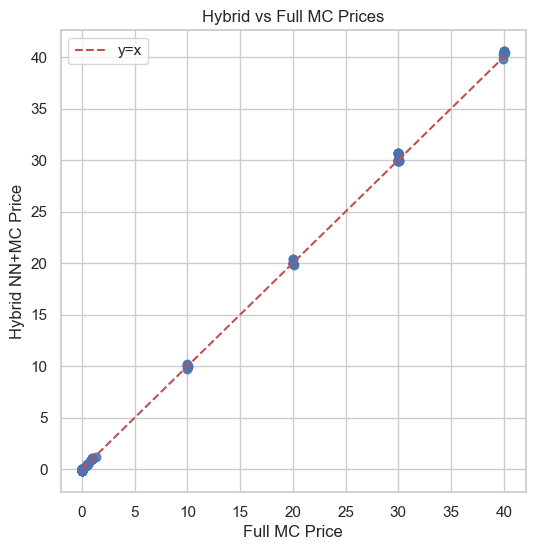

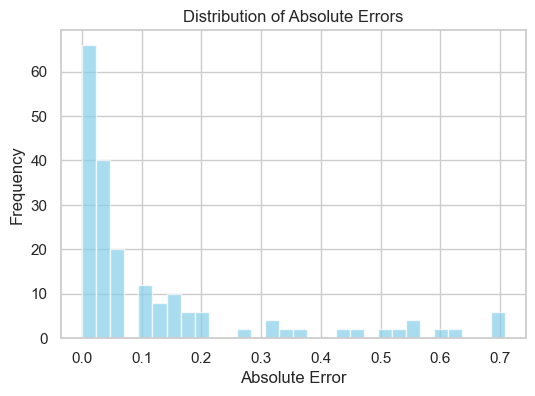

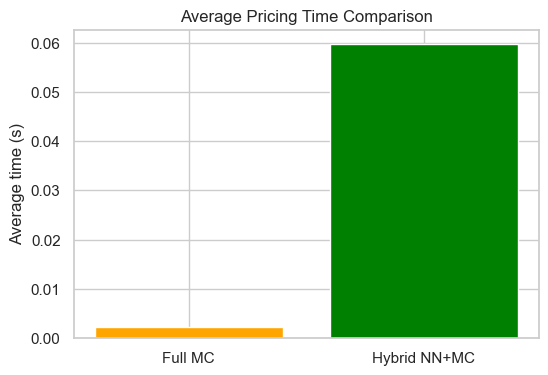

C:\Users\aisha\AppData\Local\Temp\ipykernel_12512\2884340005.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=OPTION_TYPES.values())


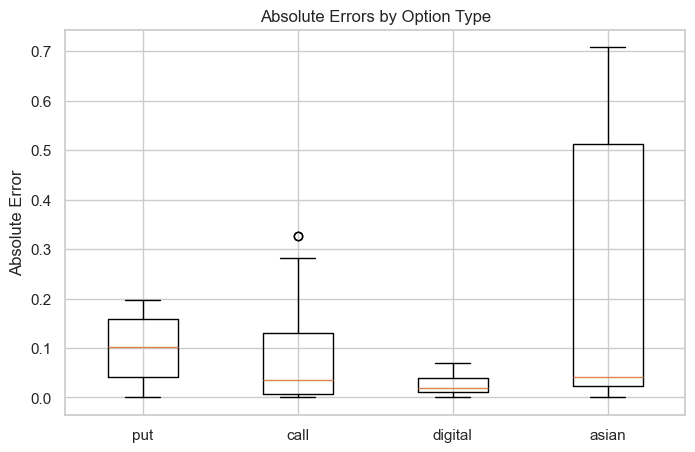

In [38]:
import seaborn as sns
sns.set(style="whitegrid")

# Scatter: Full MC vs Hybrid
plt.figure(figsize=(6,6))
plt.scatter(full_prices, hybrid_prices, alpha=0.6)
plt.plot([min(full_prices), max(full_prices)], [min(full_prices), max(full_prices)], 'r--', label="y=x")
plt.xlabel("Full MC Price")
plt.ylabel("Hybrid NN+MC Price")
plt.title("Hybrid vs Full MC Prices")
plt.legend()
plt.show()

# Absolute error histogram
plt.figure(figsize=(6,4))
plt.hist(abs_errors, bins=30, alpha=0.7, color="skyblue")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Errors")
plt.show()

# Timing comparison
plt.figure(figsize=(6,4))
plt.bar(["Full MC", "Hybrid NN+MC"], [np.mean(full_times), np.mean(hybrid_times)], color=["orange","green"])
plt.ylabel("Average time (s)")
plt.title("Average Pricing Time Comparison")
plt.show()

# Boxplots per option type
plt.figure(figsize=(8,5))
data_to_plot = [per_type_errors[opt] for opt in OPTION_TYPES.values()]
plt.boxplot(data_to_plot, labels=OPTION_TYPES.values())
plt.ylabel("Absolute Error")
plt.title("Absolute Errors by Option Type")
plt.show()

In [48]:
SAMPLES_TO_TEST = 200  
FULL_MC_PATHS = 50000     # expensive baseline
REDUCED_MC_PATHS = 100    # hybrid
PREFIX_LEN = 10
N_STEPS = 50
S0 = 100
SEED = 123
OPTION_MAP = {0: "put", 1: "call", 2: "digital", 3: "asian"}

In [49]:
# Load raw data
data = np.load(RAW_DATA_PATH)
X, y_true = data["X"], data["y"]
scaler = joblib.load(SCALER_PATH)

# Load the target model
model_file = "mlp_large_deep_residual.keras"
nn_model = load_model(os.path.join(MODEL_DIR, model_file), compile=False)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="mse", metrics=["mae"])

# Pick samples to test
X_eval, y_eval = X[:SAMPLES_TO_TEST], y_true[:SAMPLES_TO_TEST]

times_full = []
times_hybrid = []
abs_errors = []
rel_errors = []
option_flags = []

In [50]:
for i, x in enumerate(X_eval):
    K, T, r, sigma, option_flag = x[-5:]
    option_flags.append(option_flag)

    # ---------------------
    # Full MC
    # ---------------------
    start = time.time()
    paths_full = simulate_gbm_paths(S0, r, sigma, T, N_STEPS, FULL_MC_PATHS, seed=SEED+i)
    if option_flag == 1.0:  # call
        payoff_full = np.maximum(paths_full[:, -1] - K, 0)
    elif option_flag == 0.0:  # put
        payoff_full = np.maximum(K - paths_full[:, -1], 0)
    elif option_flag == 2.0:  # digital
        payoff_full = (paths_full[:, -1] > K).astype(float)
    elif option_flag == 3.0:  # asian
        payoff_full = np.maximum(np.mean(paths_full, axis=1) - K, 0)
    full_mc_price = discount_payoff(payoff_full, r, T).mean()
    end = time.time()
    times_full.append(end - start)

    # ---------------------
    # Hybrid NN+MC
    # ---------------------
    start = time.time()
    paths_reduced = simulate_gbm_paths(S0, r, sigma, T, N_STEPS, REDUCED_MC_PATHS, seed=SEED+i)
    hybrid_price = evaluate_hybrid_nn(paths_reduced, scaler, nn_model, K, T, r, sigma, option_flag)
    end = time.time()
    times_hybrid.append(end - start)

    abs_err = np.abs(hybrid_price - full_mc_price)
    rel_err = abs_err / max(full_mc_price, 1e-8)
    abs_errors.append(abs_err)
    rel_errors.append(rel_err)

    print(f"{i:3d} | Option: {OPTION_MAP[int(option_flag)]} | Full MC: {full_mc_price:8.4f} | "
            f"Hybrid: {hybrid_price:8.4f} | AbsErr: {abs_err:8.4f} | RelErr: {rel_err:6.2%}")

print("\n--- Overall Summary ---")
print(f"Avg Full MC time: {np.mean(times_full):.4f} s")
print(f"Avg Hybrid time: {np.mean(times_hybrid):.4f} s")
print(f"Speed-up factor (Full/Hybrid): {np.mean(times_full)/np.mean(times_hybrid):.4f}")
print(f"Avg absolute error: {np.mean(abs_errors):.4f}")
print(f"Median absolute error: {np.median(abs_errors):.4f}")

  0 | Option: put | Full MC:   0.0000 | Hybrid:  -0.1567 | AbsErr:   0.1567 | RelErr: 1567021161.32%
  1 | Option: call | Full MC:   1.4040 | Hybrid:   1.2715 | AbsErr:   0.1325 | RelErr:  9.44%
  2 | Option: digital | Full MC:   0.4909 | Hybrid:   0.4668 | AbsErr:   0.0241 | RelErr:  4.90%
  3 | Option: put | Full MC:  10.0046 | Hybrid:   9.9880 | AbsErr:   0.0166 | RelErr:  0.17%
  4 | Option: put | Full MC:  29.9852 | Hybrid:  29.8655 | AbsErr:   0.1197 | RelErr:  0.40%
  5 | Option: digital | Full MC:   0.0000 | Hybrid:   0.0165 | AbsErr:   0.0165 | RelErr: 165181271.73%
  6 | Option: asian | Full MC:   0.3571 | Hybrid:   0.3082 | AbsErr:   0.0489 | RelErr: 13.70%
  7 | Option: put | Full MC:   0.0000 | Hybrid:  -0.1064 | AbsErr:   0.1064 | RelErr: 1063646674.16%
  8 | Option: digital | Full MC:   1.0000 | Hybrid:   0.9998 | AbsErr:   0.0002 | RelErr:  0.02%
  9 | Option: asian | Full MC:  39.9961 | Hybrid:  40.5471 | AbsErr:   0.5509 | RelErr:  1.38%
 10 | Option: put | Full MC:  

In [51]:
print("\n--- Per Option Type Metrics ---")
option_flags_np = np.array(option_flags)
abs_errors_np = np.array(abs_errors)
rel_errors_np = np.array(rel_errors)
times_full_np = np.array(times_full)
times_hybrid_np = np.array(times_hybrid)

for opt_flag, name in OPTION_MAP.items():
    idx = np.where(option_flags_np == opt_flag)[0]
    if len(idx) == 0:
        continue
    print(f"{name:6} | Avg Abs Err: {abs_errors_np[idx].mean():.4f} | "
            f"Median Abs Err: {np.median(abs_errors_np[idx]):.4f} | "
            f"Avg Rel Err: {rel_errors_np[idx].mean()*100:6.2f}% | "
            f"Avg Full MC time: {times_full_np[idx].mean():.4f} s | "
            f"Avg Hybrid time: {times_hybrid_np[idx].mean():.4f} s")


--- Per Option Type Metrics ---
put    | Avg Abs Err: 0.1288 | Median Abs Err: 0.1197 | Avg Rel Err: 749932119.14% | Avg Full MC time: 0.0667 s | Avg Hybrid time: 0.0449 s
call   | Avg Abs Err: 0.0760 | Median Abs Err: 0.0475 | Avg Rel Err: 20621453.83% | Avg Full MC time: 0.0681 s | Avg Hybrid time: 0.0439 s
digital | Avg Abs Err: 0.0313 | Median Abs Err: 0.0240 | Avg Rel Err: 58481772.31% | Avg Full MC time: 0.0675 s | Avg Hybrid time: 0.0439 s
asian  | Avg Abs Err: 0.2211 | Median Abs Err: 0.0398 | Avg Rel Err: 81585865.19% | Avg Full MC time: 0.0681 s | Avg Hybrid time: 0.0448 s


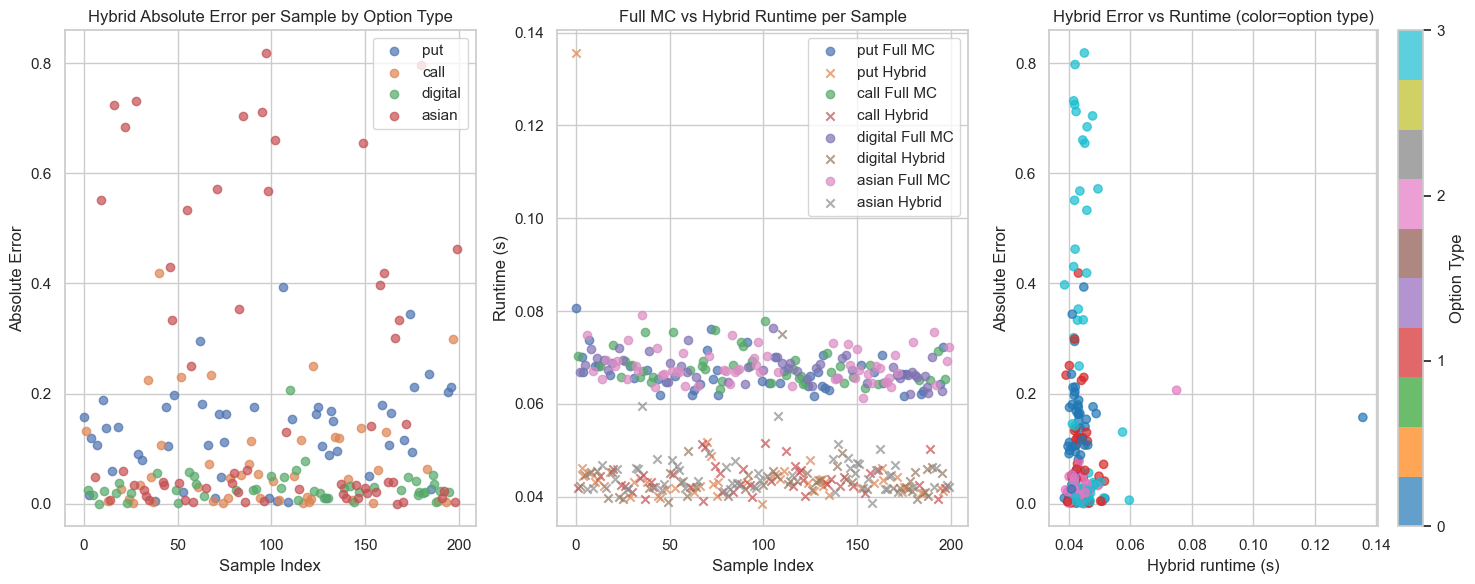

In [52]:
plt.figure(figsize=(15, 6))

# Absolute error per sample by option type
plt.subplot(1, 3, 1)
for opt_flag, name in OPTION_MAP.items():
    idx = np.where(option_flags_np == opt_flag)[0]
    plt.scatter(idx, abs_errors_np[idx], label=name, alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Absolute Error")
plt.title("Hybrid Absolute Error per Sample by Option Type")
plt.legend()
plt.grid(True)

# Timing comparison
plt.subplot(1, 3, 2)
for opt_flag, name in OPTION_MAP.items():
    idx = np.where(option_flags_np == opt_flag)[0]
    plt.scatter(idx, times_full_np[idx], marker='o', label=f"{name} Full MC", alpha=0.7)
    plt.scatter(idx, times_hybrid_np[idx], marker='x', label=f"{name} Hybrid", alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Runtime (s)")
plt.title("Full MC vs Hybrid Runtime per Sample")
plt.legend()
plt.grid(True)

# Absolute error vs hybrid runtime
plt.subplot(1, 3, 3)
plt.scatter(times_hybrid_np, abs_errors_np, c=option_flags_np, cmap='tab10', alpha=0.7)
plt.xlabel("Hybrid runtime (s)")
plt.ylabel("Absolute Error")
plt.title("Hybrid Error vs Runtime (color=option type)")
plt.colorbar(ticks=[0,1,2,3], label='Option Type')
plt.grid(True)

plt.tight_layout()
plt.show()